In [2]:
%pip install scikit-learn xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np


%matplotlib inline

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

Работаем на CPU


In [ ]:
!pip install timm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import timm

In [ ]:
timm.list_models("*resnet*", pretrained=True)

['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet18d.ra4

In [ ]:
pretrained_model = timm.create_model('resnet50.a1_in1k', pretrained=True)

In [9]:
# Вывод архитектуры модели
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [10]:
transforms_stats = v2.Compose([
    torchvision.transforms.RandomResizedCrop(224),  # Случайное кадрирование до 224x224
    torchvision.transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
	torchvision.transforms.ToTensor()             # Преобразование изображения в тензор
])

stats_dataset = ImageFolder(root="./animal_data/animal_dataset/train", transform=transforms_stats)

In [11]:
imgs = [item[0] for item in stats_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(f"Means R, G, B: {mean_r,mean_g,mean_b}")

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(f"Std R, G, B: {std_r,std_g,std_b}")

c:\Users\agd01\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Means R, G, B: (0.5165079, 0.48544136, 0.42094523)
Std R, G, B: (0.2716211, 0.26593277, 0.27608067)


In [ ]:
transforms_train = v2.Compose([
    torchvision.transforms.RandomResizedCrop(224),  # Случайное кадрирование до 224x224
    torchvision.transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
	torchvision.transforms.ToTensor(),             # Преобразование изображения в тензор
	v2.Normalize(mean=[mean_r,mean_g,mean_b], std=[std_r,std_g,std_b]) # Нормализация с вычисленными средними и отклонениями
])

transforms_test = v2.Compose([
    torchvision.transforms.RandomResizedCrop(224),  
    torchvision.transforms.RandomHorizontalFlip(), 
	torchvision.transforms.ToTensor(),             
	v2.Normalize(mean=[mean_r,mean_g,mean_b], std=[std_r,std_g,std_b]) 
])

In [13]:
train_dataset = ImageFolder(
	root='./animal_data/animal_dataset/train',
	transform=transforms_train
)

test_dataset = ImageFolder(
	root='./animal_data/animal_dataset/test',
	transform=transforms_test
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


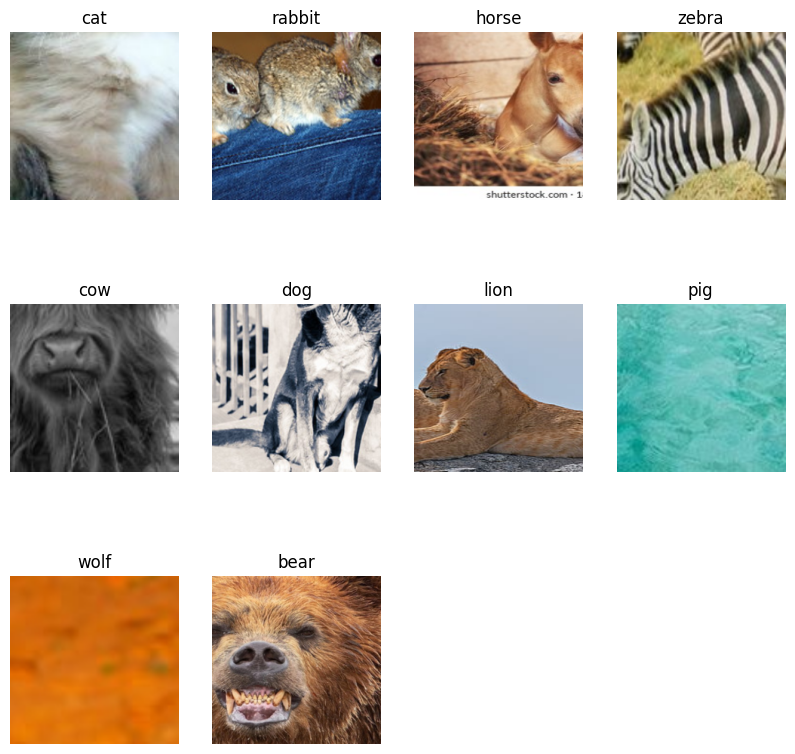

In [14]:
mean = [mean_r,mean_g,mean_b]
std = [std_r,std_g,std_b]
draw_label = []

labels_map = dict(zip(range(len(train_dataset.classes)), train_dataset.classes))
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 3
for i in range(1, 11):
	flag = 0
	while flag == 0:
		sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
		img, label = train_dataset[sample_idx]
		if label not in (draw_label):
			draw_label.append(label)
			flag = 1

	# Денормализация
	img = img.clone()
	for channel in range(3):
		img[channel] = img[channel] * std[channel] + mean[channel]

	# Переводим изображение в формат (H, W, C) для корректного отображения
	img = img.permute(1, 2, 0).numpy()

	figure.add_subplot(rows, cols, i)
	plt.title(labels_map[label])
	plt.axis("off")
	plt.imshow(img)
plt.show()

In [15]:
BATCH_SIZE = 32

train_loader = DataLoader(
	train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True
)

test_loader = DataLoader(
	test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False
)

In [ ]:
# "Замораживаем" веса
for param in pretrained_model.parameters():
    param.requires_grad = False

num_classes = 10  # Количество классов в задаче


pretrained_model.fc = nn.Sequential(
    nn.Linear(pretrained_model.fc.in_features, 256),  # Промежуточный слой
    nn.ReLU(),                                       # Активация
    nn.Dropout(0.3),                                 # Dropout для регуляризации
    nn.Linear(256, num_classes)                     # Выходной слой
)

In [17]:
loss_fn = nn.CrossEntropyLoss() # Определяем функцию потерь
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001) # Определяем оптимизатор

In [18]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    # Переключение модели в режим обучения
    pretrained_model.train()

    # Обучение
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Перенос данных на устройство
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = pretrained_model(images)
        loss = loss_fn(outputs, labels)

        # Обратное распространение
        loss.backward()

        # Шаг оптимизации
        optimizer.step()

        # Накопление метрик
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Вычисление средней потери и точности для обучения
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Переключение модели в режим оценки
    pretrained_model.eval()

    # Тестирование
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Перенос данных на устройство
            images, labels = images.to(device), labels.to(device)

            # Прямой проход
            outputs = pretrained_model(images)
            loss = loss_fn(outputs, labels)

            # Накопление метрик
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    # Вычисление средней потери и точности для теста
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    # Шаг планировщика
    scheduler.step()

    # Вывод метрик за эпоху
    print(
        f"Epoch {epoch + 1}/{num_epochs}: "
        f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

Epoch 1/10: Train Loss: 1.8545, Train Accuracy: 0.4458, Test Loss: 1.3248, Test Accuracy: 0.8421
Epoch 2/10: Train Loss: 1.0075, Train Accuracy: 0.7898, Test Loss: 0.5974, Test Accuracy: 0.8835
Epoch 3/10: Train Loss: 0.6892, Train Accuracy: 0.8388, Test Loss: 0.4923, Test Accuracy: 0.9060
Epoch 4/10: Train Loss: 0.5755, Train Accuracy: 0.8633, Test Loss: 0.4714, Test Accuracy: 0.8910
Epoch 5/10: Train Loss: 0.5177, Train Accuracy: 0.8803, Test Loss: 0.3886, Test Accuracy: 0.9098
Epoch 6/10: Train Loss: 0.5238, Train Accuracy: 0.8652, Test Loss: 0.3482, Test Accuracy: 0.9286
Epoch 7/10: Train Loss: 0.4775, Train Accuracy: 0.8643, Test Loss: 0.3537, Test Accuracy: 0.9098
Epoch 8/10: Train Loss: 0.4703, Train Accuracy: 0.8803, Test Loss: 0.3161, Test Accuracy: 0.9248
Epoch 9/10: Train Loss: 0.4665, Train Accuracy: 0.8888, Test Loss: 0.3773, Test Accuracy: 0.9060
Epoch 10/10: Train Loss: 0.4441, Train Accuracy: 0.8775, Test Loss: 0.3272, Test Accuracy: 0.9248


In [20]:

# Второй вариант
n = 2
for param in pretrained_model.layer4[-n:].parameters():
    param.requires_grad = True



In [21]:
# Новый набор объектов

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': pretrained_model.layer4.parameters(), 'lr': 1e-4},  # Размороженные параметры layer4
    {'params': pretrained_model.fc.parameters(), 'lr': 1e-3},     # Размороженные параметры fc
], lr=1e-2, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.3)

In [ ]:
# Новый цикл обучения

for epoch in range(num_epochs):
    # Перевод модели в режим обучения
    pretrained_model.train()

    # Обучение
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Перенос данных на устройство
        images, labels = images.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = pretrained_model(images)

        # Вычисление потерь
        loss = loss_fn(outputs, labels)

        # Обратное распространение ошибки
        loss.backward()

        # Шаг оптимизации
        optimizer.step()

        # Накопление метрик
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Вычисление средней потери и точности для обучения
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Тестирование
    pretrained_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_model(images)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    # Вычисление средней потери и точности для теста
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    # Шаг планировщика
    scheduler.step()

    # Вывод метрик за эпоху
    print(
        f"Epoch {epoch + 1}/{num_epochs}: "
        f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

Epoch 1/10: Train Loss: 0.4729, Train Accuracy: 0.8812, Test Loss: 0.3523, Test Accuracy: 0.9098
Epoch 2/10: Train Loss: 0.4716, Train Accuracy: 0.8737, Test Loss: 0.3471, Test Accuracy: 0.9173
Epoch 3/10: Train Loss: 0.4401, Train Accuracy: 0.8784, Test Loss: 0.3559, Test Accuracy: 0.8985
Epoch 4/10: Train Loss: 0.4470, Train Accuracy: 0.8831, Test Loss: 0.2900, Test Accuracy: 0.9248
Epoch 5/10: Train Loss: 0.4102, Train Accuracy: 0.8935, Test Loss: 0.3243, Test Accuracy: 0.9098
Epoch 6/10: Train Loss: 0.4262, Train Accuracy: 0.8878, Test Loss: 0.3672, Test Accuracy: 0.9098
Epoch 7/10: Train Loss: 0.4882, Train Accuracy: 0.8841, Test Loss: 0.3023, Test Accuracy: 0.9398
Epoch 8/10: Train Loss: 0.4265, Train Accuracy: 0.8869, Test Loss: 0.3193, Test Accuracy: 0.9248
Epoch 9/10: Train Loss: 0.4432, Train Accuracy: 0.8992, Test Loss: 0.3127, Test Accuracy: 0.9060
Epoch 10/10: Train Loss: 0.4285, Train Accuracy: 0.8860, Test Loss: 0.3000, Test Accuracy: 0.9211


In [ ]:
from PIL import Image
import torchvision.transforms as T

# Путь к изображению
image_path = "./animal_data/korova.jpg"

# Загрузка изображения
image = Image.open(image_path).convert("RGB")

# Преобразования изображения 
transform = T.Compose([
    T.Resize((256, 256)),  # Размер, использованный при обучении
    T.ToTensor(),  # Преобразование в тензор
    T.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])  # Нормализация
])

# Применение преобразований
image_tensor = transform(image).unsqueeze(0)  # Добавление batch-измерения

# Переводим модель в режим оценки
pretrained_model.eval()

# Переносим данные на устройство
image_tensor = image_tensor.to(device)

# Классификация изображения
with torch.no_grad():
    output = pretrained_model(image_tensor)
    predicted_class = output.argmax(dim=1).item()

# Вывод предсказанного класса
print(f"Предсказанный класс: {labels_map[predicted_class]}")

Предсказанный класс: cow


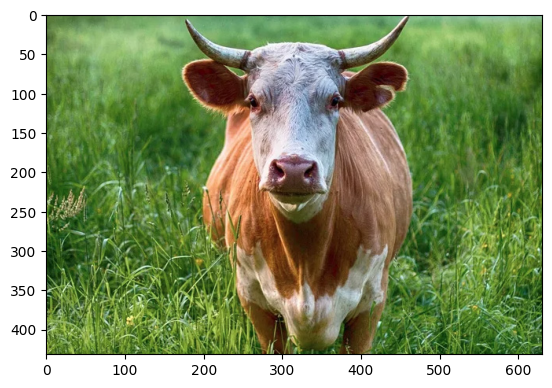

In [24]:
plt.imshow(image)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Извлечение признаков из ResNet для ML моделей
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
feature_extractor.eval()
feature_extractor.to(device)

def extract_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            output = feature_extractor(images).squeeze()
            features.append(output.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.concatenate(labels)

X_train_feats, y_train_arr = extract_features(train_loader)
X_test_feats, y_test_arr = extract_features(test_loader)


In [ ]:
# Обучение ансамблевых моделей
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feats, y_train_arr)
rf_preds = rf.predict(X_test_feats)
rf_acc = accuracy_score(y_test_arr, rf_preds)

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_feats, y_train_arr)
gb_preds = gb.predict(X_test_feats)
gb_acc = accuracy_score(y_test_arr, gb_preds)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feats, y_train_arr)
knn_preds = knn.predict(X_test_feats)
knn_acc = accuracy_score(y_test_arr, knn_preds)

voting = VotingClassifier(estimators=[
    ('rf', rf),
    ('gb', gb),
    ('knn', knn)
], voting='soft')
voting.fit(X_train_feats, y_train_arr)
voting_preds = voting.predict(X_test_feats)
voting_acc = accuracy_score(y_test_arr, voting_preds)


In [27]:
print(f"\n📊 Accuracy сравнение моделей:")
print(f"ResNet (последний запуск):        {test_accuracy:.4f}")
print(f"Random Forest:                    {rf_acc:.4f}")
print(f"Gradient Boosting:                {gb_acc:.4f}")
print(f"K-Nearest Neighbors:              {knn_acc:.4f}")
print(f"VotingClassifier (RF + GB + KNN): {voting_acc:.4f}")



📊 Accuracy сравнение моделей:
ResNet (последний запуск):        0.9211
Random Forest:                    0.8083
Gradient Boosting:                0.7895
K-Nearest Neighbors:              0.7857
VotingClassifier (RF + GB + KNN): 0.8346


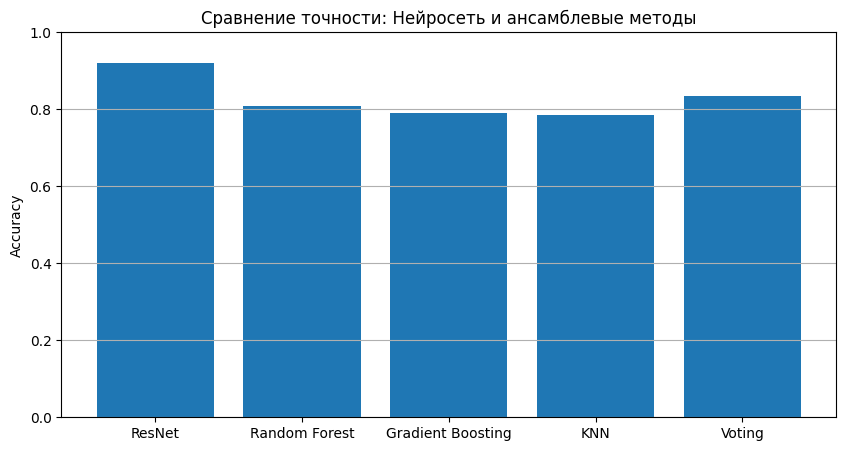

In [28]:
models = ['ResNet', 'Random Forest', 'Gradient Boosting', 'KNN', 'Voting']
accuracies = [test_accuracy, rf_acc, gb_acc, knn_acc, voting_acc]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Сравнение точности: Нейросеть и ансамблевые методы")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Настройка предобученной модели ResNet50 для извлечения признаков
pretrained_model.eval()  # перевод модели в режим оценки
pretrained_model.fc = nn.Identity()  # замена финального классифицирующего слоя на идентичный
pretrained_model.to(device)

# 2. Извлечение признаков из обучающего и тестового наборов
train_features = []
train_labels = []
with torch.no_grad():  # отключение вычисления градиентов для ускорения
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        feats = pretrained_model(images)             # получение признаков размерностью 2048
        feats = feats.cpu().numpy()       # переносим на CPU и в numpy
        labels = labels.cpu().numpy()     # метки классов на CPU (numpy)
        train_features.append(feats)
        train_labels.append(labels)
# Объединение списков в единые массивы признаков и меток для обучения
X_train = np.concatenate(train_features, axis=0)
y_train = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        feats = pretrained_model(images)
        feats = feats.cpu().numpy()
        labels = labels.cpu().numpy()
        test_features.append(feats)
        test_labels.append(labels)
X_test = np.concatenate(test_features, axis=0)
y_test = np.concatenate(test_labels, axis=0)


try:
    class_names = list(train_loader.dataset.classes)
except AttributeError:
    num_classes = len(np.unique(y_train))
    class_names = [str(i) for i in range(num_classes)]

print("Features extracted:")
print(f"Train set: {X_train.shape} features, {y_train.shape} labels")
print(f"Test set:  {X_test.shape} features, {y_test.shape} labels")


c:\Users\agd01\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Features extracted:
Train set: (1061, 2048) features, (1061,) labels
Test set:  (266, 2048) features, (266,) labels


In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 3. Обучение ансамблевых моделей на признаках (CPU)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Обучение Random Forest
rf_model.fit(X_train, y_train)
# Обучение Gradient Boosting
gb_model.fit(X_train, y_train)

print("Ensemble models trained:")
print(f"Random Forest trees: {rf_model.n_estimators}, Depth: {rf_model.max_depth}")
print(f"Gradient Boosting iterations: {gb_model.n_estimators}, Learning rate: {gb_model.learning_rate}")


Ensemble models trained:
Random Forest trees: 100, Depth: None
Gradient Boosting iterations: 100, Learning rate: 0.1


In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 4. Предсказания на тестовом наборе
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# 5. Точность (Accuracy) на тестовой выборке
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"Gradient Boosting Accuracy: {acc_gb:.4f}\n")

# 6. Подробный отчет по классам (precision, recall, F1-score)
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))
print("Gradient Boosting - Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=class_names))


Random Forest Accuracy: 0.8534
Gradient Boosting Accuracy: 0.8421

Random Forest - Classification Report:
              precision    recall  f1-score   support

        bear       1.00      0.80      0.89        25
         cat       0.79      0.90      0.84        29
         cow       0.73      0.67      0.70        24
         dog       0.64      0.88      0.74        32
       horse       0.89      0.74      0.81        23
        lion       1.00      0.88      0.94        26
         pig       0.92      0.69      0.79        16
      rabbit       0.89      0.91      0.90        34
        wolf       0.91      0.94      0.93        33
       zebra       1.00      1.00      1.00        24

    accuracy                           0.85       266
   macro avg       0.88      0.84      0.85       266
weighted avg       0.87      0.85      0.86       266

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

        bear       0.80      0.80    

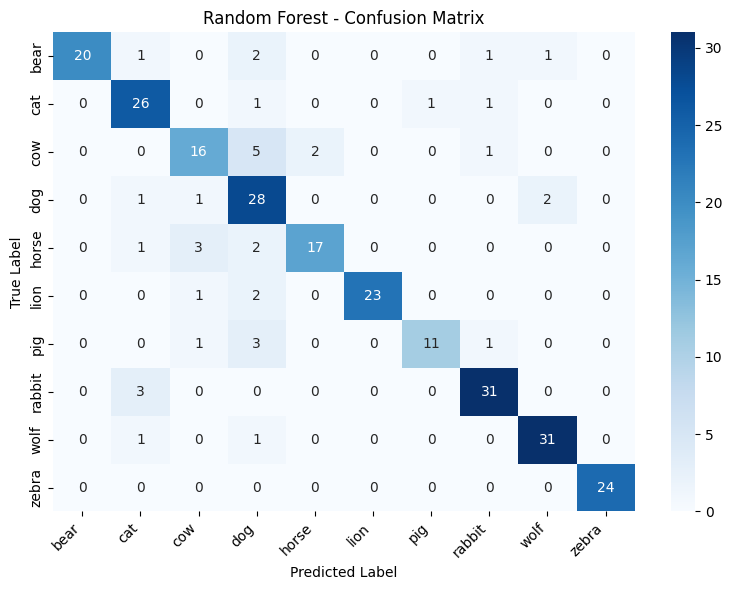

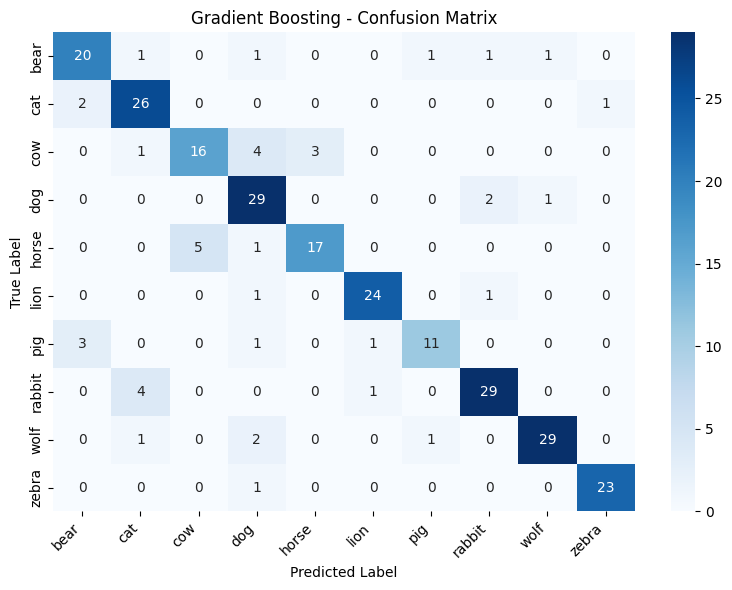

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 7. Матрица ошибок для Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 8. Матрица ошибок для Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


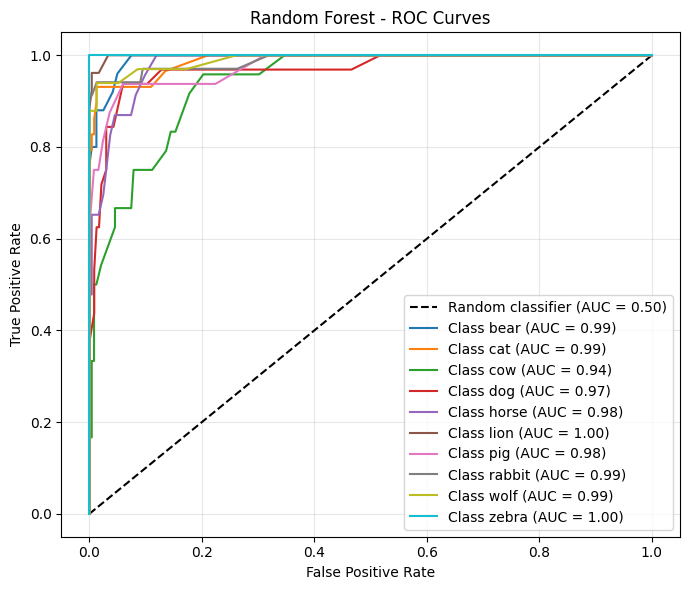

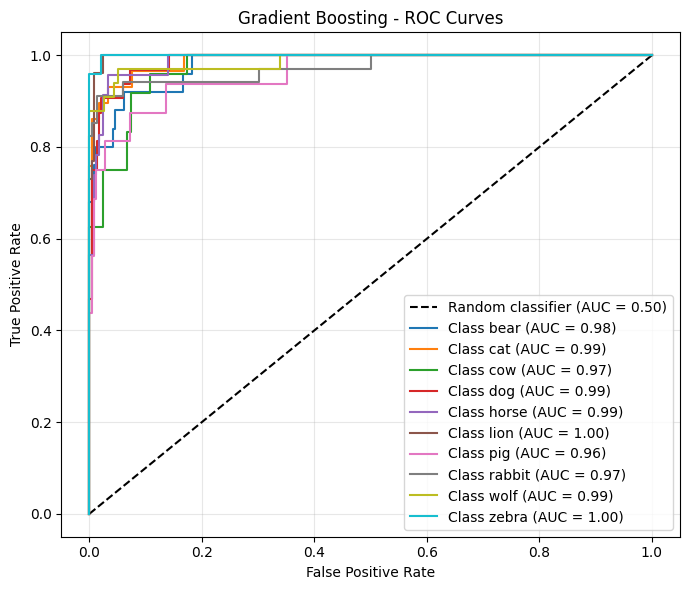

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Бинаризуем метки классов для расчета ROC (one-vs-all)
num_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))

# 9. ROC-кривые для Random Forest
y_score_rf = rf_model.predict_proba(X_test)  # вероятности классов
fpr_rf = {}  # False Positive Rate на разных порогах для каждого класса
tpr_rf = {}  # True Positive Rate для каждого класса
roc_auc_rf = {}
plt.figure(figsize=(7,6))
# Диагональ случайной модели
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier (AUC = 0.50)")
# Для каждого класса строим ROC-кривую
for i in range(num_classes):
    if y_test_bin[:, i].sum() == 0:
        continue  # пропустить класс, отсутствующий в тестовой выборке
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    plt.plot(fpr_rf[i], tpr_rf[i], label=f"Class {class_names[i]} (AUC = {roc_auc_rf[i]:.2f})")
plt.title("Random Forest - ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 10. ROC-кривые для Gradient Boosting
y_score_gb = gb_model.predict_proba(X_test)
fpr_gb = {}
tpr_gb = {}
roc_auc_gb = {}
plt.figure(figsize=(7,6))
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier (AUC = 0.50)")
for i in range(num_classes):
    if y_test_bin[:, i].sum() == 0:
        continue
    fpr_gb[i], tpr_gb[i], _ = roc_curve(y_test_bin[:, i], y_score_gb[:, i])
    roc_auc_gb[i] = auc(fpr_gb[i], tpr_gb[i])
    plt.plot(fpr_gb[i], tpr_gb[i], label=f"Class {class_names[i]} (AUC = {roc_auc_gb[i]:.2f})")
plt.title("Gradient Boosting - ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
